In [1]:
from sympy import *      
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.signal as sp

init_session       # Denotes that, an interactive sympy session has begun
s = symbols('s')   # The symbol for denoting the 's' parameter in Laplace transforms

In [2]:
def lowpass(R1,R2,C1,C2,G,Vi):
    s=symbols('s')
    A=Matrix([[0,0,1,-1/G],[-1/(1+s*R2*C2),1,0,0], [0,-G,G,1],[-(1/R1)-(1/R2)-(s*C1),1/R2,0,s*C1]])
    b=Matrix([0,0,0,-Vi/R1])
    V=A.inv()*b
    return (A,b,V)

In [ ]:
def bandpass(R1,R2,C1,C2,G,Vi):
    s=symbols('s')
    A=Matrix([[0,0,1,-1/G],[-1/(1+s*R2*C2),1,0,0], [0,-G,G,1],[-(1/R1)-(1/R2)-(s*C1),1/R2,0,s*C1]])
    b=Matrix([0,0,0,-Vi/R1])
    V=A.inv()*b
    return (A,b,V)

In [3]:
def highpass(R1,R3,C1,C2,G,Vi):
    s=symbols('s')
    A=Matrix([[0,0,1,-1/G],[-(s*R3*C2)/(1+s*R3*C2),1,0,0], [0,-G,G,1],[-(s*C1)-(s*C2)-(1/R1),s*C2,0,1/R1]])
    b=Matrix([0,0,0,-Vi*s*C1])
    V=A.inv()*b
    return (A,b,V)

In [4]:
def get_response_freq_domain(h,filterType):
    if (filterType == 'l'):              # Low pass filter condition
        A,b,V = lowpass(10000,10000,1e-9,1e-9,1.586,h)
    elif (filterType == 'h'):            # High pass filter condition
        A,b,V = highpass(10000,10000,1e-9,1e-9,1.586,h)
    Vo=V[3]                              # The 4th element is Vo

    # The below lines convert the sympy expression to a numpy function and get values for the resultant equation
    w=np.logspace(0,8,801)
    ss=1j*w
    hf=lambdify(s,Vo,'numpy')
    v=hf(ss)
    return Vo,w,abs(v),np.angle(v)       # Vo is returned so as to calculate time domain output later

In [5]:
def get_numpy_array_from_Poly(num,den):   # This is called only from the function declared below
    isFloat = False
    try:
        num = Poly(num).all_coeffs()      # If the numerator is just a constant value, this line will throw an error
    except GeneratorsNeeded:
        num = num                         # If an error is thrown above, it means numerator is just a constant and hence, use as is
        isFloat = True
    den = Poly(den).all_coeffs()          # Get coefficients of denominator
    
    # The below steps are required as the coefficients obtained above are not in a proper format to be used in numpy.poly1d(), so a numpy array is generated from the above values, and then returned to the parent function.
    den2 = []
    num2 = []
    for i in den:
        den2.append(float(i))
    den2 = np.array(den2)
    
    if (isFloat):   # If numerator is a constant, no need to iterate through it
        num2 = num
    else:
        for i in num:
            num2.append(float(i))
        num2 = np.array(num2)
    return num2,den2

In [6]:
def get_output_time_domain(Y,t,steps):
    simplY = simplify(Y)     # This gets the simplified expression of laplace transform
    num = fraction(simplY)[0]   # Gets numerator of transform
    den = fraction(simplY)[1]   # Gets denominator of transform
    num2,den2 = get_numpy_array_from_Poly(num,den)  # This converts the Poly() object obtained above to a numpy array
    
    # Calculate poly1d expressions for numerator and denominator
    num2 = np.poly1d(num2) 
    den2 = np.poly1d(den2)
    
    # Use scipy signal toolbox to get final output waveform
    Y = sp.lti(num2,den2)
    t = np.linspace(0.0,t,steps)
    t,y=sp.impulse(Y,None,t)
    return t,y

In [7]:
def get_output_with_lsim(H,x,t): 

    # The lines below are similar to that in get_output_time_domain() function
    simplH = simplify(H)
    num = fraction(simplH)[0]
    den = fraction(simplH)[1]
    num2,den2 = get_numpy_array_from_Poly(num,den)
    
    num2 = np.poly1d(num2)
    den2 = np.poly1d(den2)
    
    H = sp.lti(num2,den2)
    t,y,sec=sp.lsim(H,x,t)   # Here, lsim() is used to find output from time domain input.
    return t,y

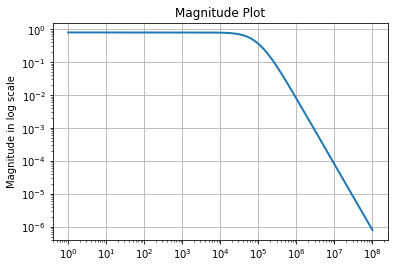

In [20]:
Vi = 1
H_l,w,v,ph = get_response_freq_domain(Vi,'l')

# The Bode plots of transfer function are plotted
#fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex = True)
plt.loglog(w,v,lw=2)
plt.grid()
plt.ylabel('Magnitude in log scale')
plt.title('Magnitude Plot')

plt.show()

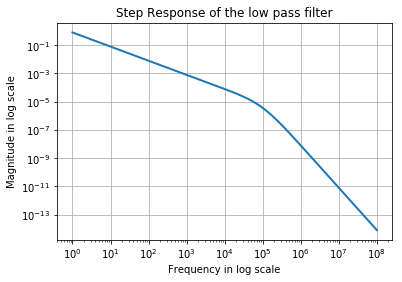

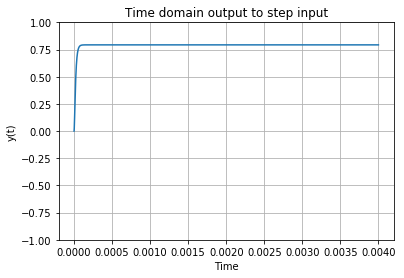

In [9]:
Vi = 1/s
Y,w,v,ph = get_response_freq_domain(Vi,'l')
t,y = get_output_time_domain(Y,4e-3,10001)

# The magnitude plot of the Laplace transform of the output is plotted
plt.loglog(w,v,lw=2)
plt.grid()
plt.title('Step Response of the low pass filter')
plt.xlabel('Frequency in log scale')
plt.ylabel('Magnitude in log scale')
plt.show()

# The time domain output is plotted 
plt.plot(t,y)
plt.grid()
plt.title('Time domain output to step input')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.ylim(-1,1)
plt.show()

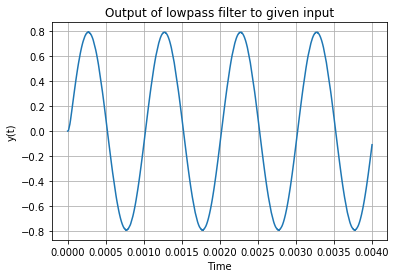

In [18]:
t = np.linspace(0.0,4e-3,100001)     # Time for which output is to be calculated
x = np.sin(2000*math.pi*t) + np.cos(2*(10**6)*math.pi*t)   # Input wave is declared
t,y = get_output_with_lsim(H_l,x,t)   # The transfer function calculated before is used here

#fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey = True)
plt.plot(t,y)
plt.grid()
plt.title('Output of lowpass filter to given input')
plt.xlabel('Time')
plt.ylabel('y(t)')

plt.show()

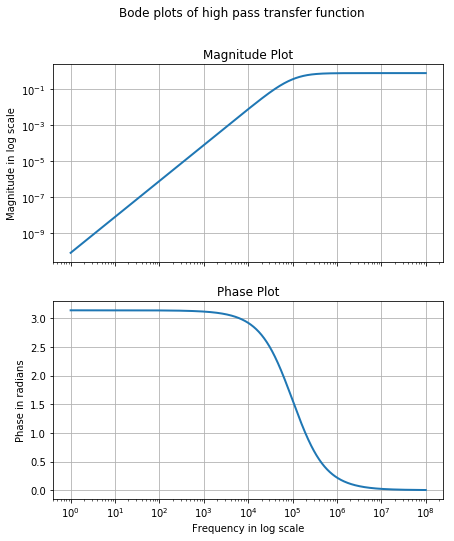

In [11]:
Vi = 1
H_h,w,v,ph = get_response_freq_domain(Vi,'h')  # Here, 'h' is passed to the function to use the high pass filter equations

# The transfer function is plotted
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex = True)
plt.suptitle('Bode plots of high pass transfer function')
axes[0].loglog(w,v,lw=2)
axes[0].grid()
axes[0].set_ylabel('Magnitude in log scale')
axes[0].set_title('Magnitude Plot')

axes[1].semilogx(w,ph,lw=2)
axes[1].grid()
axes[1].set_xlabel('Frequency in log scale')
axes[1].set_ylabel('Phase in radians')
axes[1].set_title('Phase Plot')
plt.show()

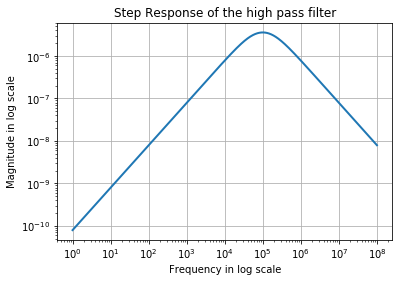

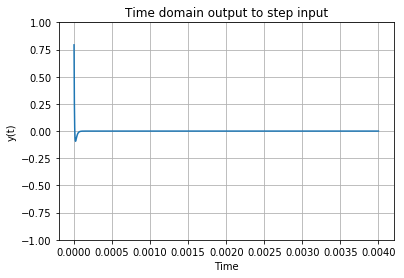

In [12]:
Vi = 1/s
Y,w,v,ph = get_response_freq_domain(Vi,'h')
t,y = get_output_time_domain(Y,4e-3,10001)

# The magnitude plot of the Laplace transform of the output is plotted
plt.loglog(w,v,lw=2)
plt.grid()
plt.title('Step Response of the high pass filter')
plt.xlabel('Frequency in log scale')
plt.ylabel('Magnitude in log scale')
plt.show()

# The time domain output is plotted 
plt.plot(t,y)
plt.grid()
plt.title('Time domain output to step input')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.ylim(-1,1)
plt.show()

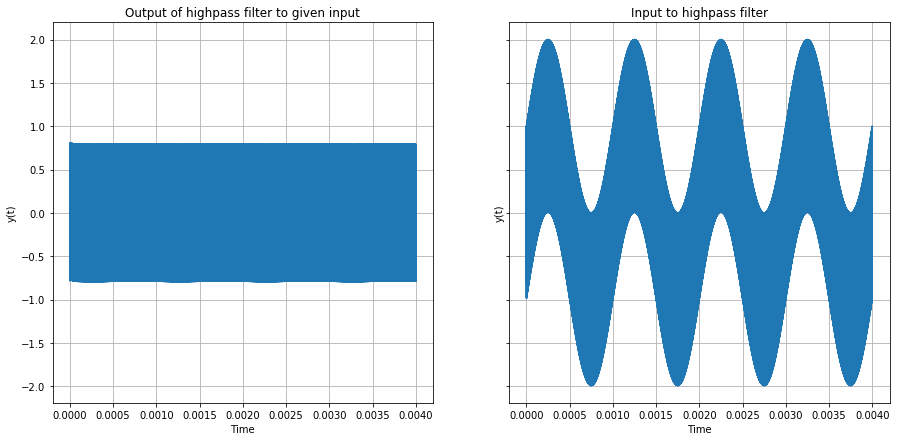

In [13]:
t = np.linspace(0.0,4e-3,100001)     # Time for which output is to be calculated
x = np.sin(2000*math.pi*t) + np.cos(2*(10**6)*math.pi*t)   # Input wave is declared
t,y = get_output_with_lsim(H_h,x,t)   # The transfer function calculated before is used here

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey = True)
axes[0].plot(t,y)
axes[0].grid()
axes[0].set_title('Output of highpass filter to given input')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('y(t)')

axes[1].plot(t,x)
axes[1].grid()
axes[1].set_title('Input to highpass filter')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('y(t)')
plt.show()

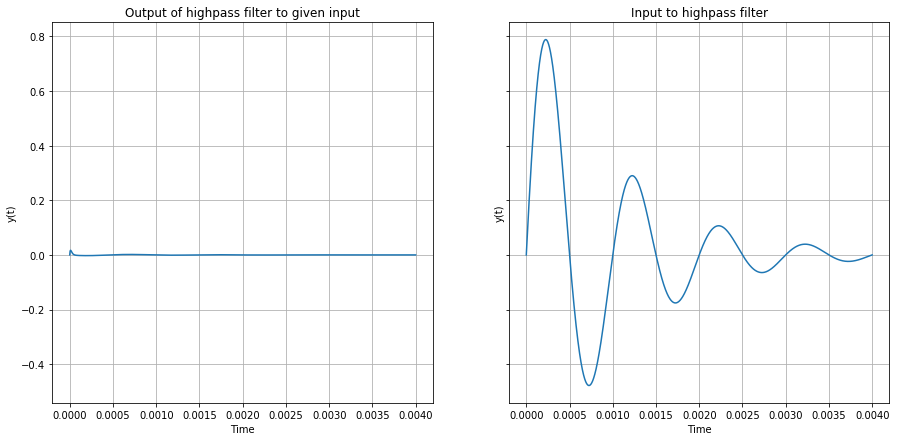

In [14]:
t = np.linspace(0.0,4e-3,100001)     # Time for which output is to be calculated
x = (np.sin(2000*math.pi*t))*np.exp((-10**3)*t)
t,y = get_output_with_lsim(H_h,x,t)   # The transfer function calculated before is used here

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey = True)
axes[0].plot(t,y)
axes[0].grid()
axes[0].set_title('Output of highpass filter to given input')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('y(t)')

axes[1].plot(t,x)
axes[1].grid()
axes[1].set_title('Input to highpass filter')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('y(t)')
plt.show()

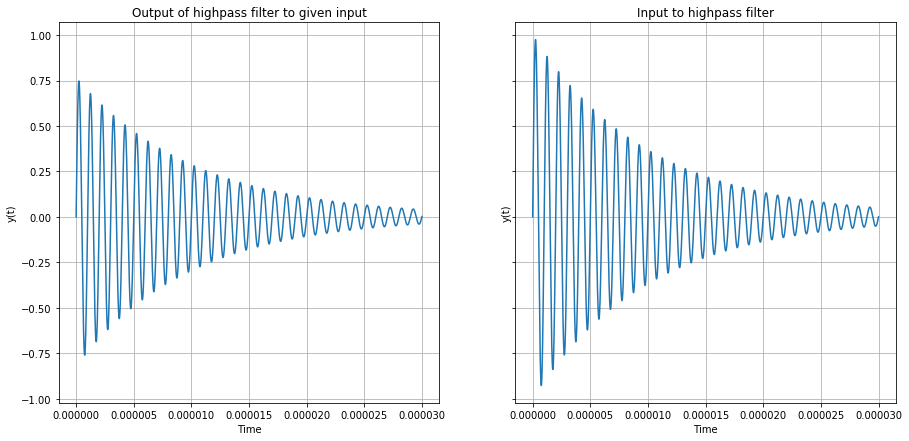

In [15]:
t = np.linspace(0.0,3e-5,100001)     # Time for which output is to be calculated
x = (np.sin(2*(10**6)*math.pi*t))*np.exp((-10**5)*t)
t,y = get_output_with_lsim(H_h,x,t)   # The transfer function calculated before is used here

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey = True)
axes[0].plot(t,y)
axes[0].grid()
axes[0].set_title('Output of highpass filter to given input')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('y(t)')

axes[1].plot(t,x)
axes[1].grid()
axes[1].set_title('Input to highpass filter')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('y(t)')
plt.show()